<a href="https://colab.research.google.com/github/Alex-So-Ma/Deep_Learning/blob/main/IAF_Proyecto_Final_M3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clasificación de tumores cerebrales CNN 2
####Alejandro Soto Malpica

Base de datos obtenida de kaggle:
https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256/data

Son imágenes obtenidas por resonacia magnética, en estas se observan los cerebros de pacientes sanos y con 3 tipos de tumores:

1. Glioma, son intra-axiales, o sea, crecen dentro de la sustancia blanda del cerebro.

2. Meningioma, este tumor parte de las meninges o membranas que envuelven y protegen el cerebro.

3. Tumores pituitarios, se desarrollan en la glándula pituitaria.

In [ ]:
#permitimos el acceso al drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Extensión tensorboard
%load_ext tensorboard

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from tensorboard.plugins.hparams import api as hp
import tensorflow as tf
from collections import OrderedDict, namedtuple
from itertools import product

from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from matplotlib.pyplot import imshow

import pickle
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import matplotlib

from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import seaborn as sns

%matplotlib inline
np.random.seed(1)

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices------------- 1


#Datos

Agregamos los dato a cuatro listas. Dos de entrenamiento y dos de prueba con las imágenes y sus respectivas etiquetas. El 10% de las imágenes van para prueba y el 90% para entrenamiento, esto de las 3096 imágenes.

In [ ]:
x_te, y_te= [], []
for file in os.listdir('/content/drive/MyDrive/Semestre 8/IAF/Data_v1/Data_test'):
    for image in os.listdir('/content/drive/MyDrive/Semestre 8/IAF/Data_v1/Data_test/'+str(file)):
        img = cv2.imread('/content/drive/MyDrive/Semestre 8/IAF/Data_v1/Data_test/'+str(file)+str('/')+str(image),0)
        x_te.append(img)
        y_te.append(file.replace('_test',''))

In [ ]:
x_tr, y_tr= [], []
for file in os.listdir('/content/drive/MyDrive/Semestre 8/IAF/Data_v1/Data_train'):
    for image in os.listdir('/content/drive/MyDrive/Semestre 8/IAF/Data_v1/Data_train/'+str(file)):
        img = cv2.imread('/content/drive/MyDrive/Semestre 8/IAF/Data_v1/Data_train/'+str(file)+str('/')+str(image),0)
        x_tr.append(img)
        y_tr.append(file.replace('_train',''))

Las cambiamos a numpy array.

In [ ]:
x_te = np.array(x_te)
y_te = np.array(y_te)
x_tr = np.array(x_tr)
y_tr = np.array(y_tr)

In [ ]:
x_te.shape, y_te.shape

((308, 256, 256), (308,))

In [ ]:
x_tr.shape, y_tr.shape

((2788, 256, 256), (2788,))

glioma_tumor


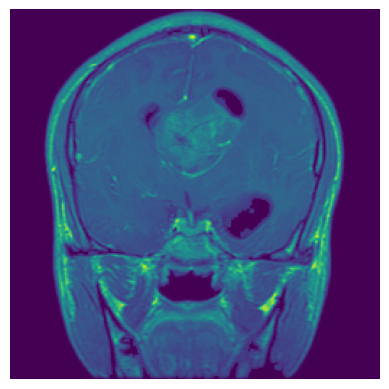

In [ ]:
n=0
plt.axis("off")
plt.imshow(x_tr[n])
print(y_tr[n])

Veamos la cantidad de datos de cada tipo.

In [ ]:
df = pd.DataFrame(data = y_tr,
                  columns = ['label'])
df['label'].value_counts()

meningioma_tumor    822
glioma_tumor        811
pituitary_tumor     760
normal              395
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

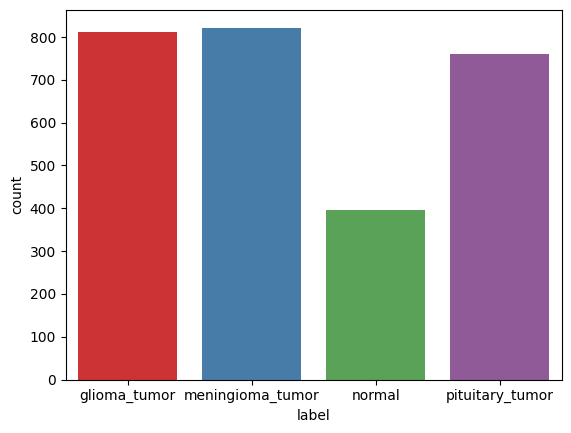

In [ ]:
sns.countplot(x = 'label', data = df, palette='Set1', width=0.8)

In [ ]:
dic = {0: 'glioma', 1: 'meningioma', 2: 'normal', 3: 'pituitaria'}
ohe = LabelEncoder()

y_train = ohe.fit_transform(y_tr)
y_test = ohe.fit_transform(y_te)

Primero vamos a aumentar la cantidad de datos de la categoría normal usando el espejo de las imágenes. Ya que todas las clases tiene mas o menos la misma cantidad de imágenes, creamos más imágenes de todas las clases rotando 90° las imágenes ya exsitentes.

In [ ]:
len_x_tr=x_tr.shape[0]
for i in range(len_x_tr):
  if y_train[i]==2:
    x_tr = np.append(x_tr, [np.fliplr(x_tr[i])], axis=0)
    y_train = np.append(y_train, y_train[i])

len_x_tr=x_tr.shape[0]
for i in range(len_x_tr):
  x_tr = np.append(x_tr, [np.rot90(x_tr[i],k=1)], axis=0)
  y_train = np.append(y_train, y_train[i])
  x_tr = np.append(x_tr, [np.rot90(np.rot90(x_tr[i],k=1),k=1)], axis=0)
  y_train = np.append(y_train, y_train[i])
  x_tr = np.append(x_tr, [np.rot90(np.rot90(np.rot90(x_tr[i],k=1),k=1),k=1)], axis=0)
  y_train = np.append(y_train, y_train[i])

df = pd.DataFrame(data = y_train,
                  columns = ['label'])
df['label'].value_counts()

1    3288
0    3244
2    3160
3    3040
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

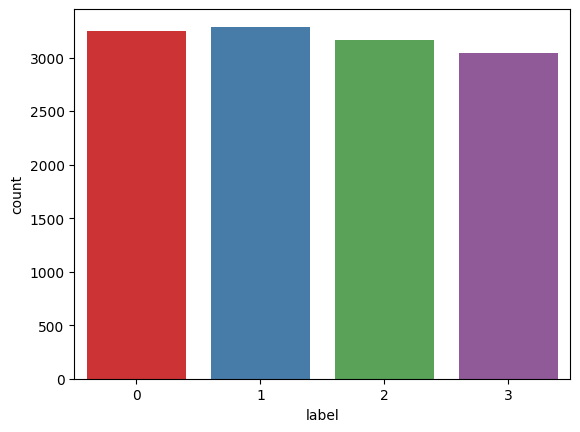

In [ ]:
sns.countplot(x = 'label', data = df, palette='Set1', width=0.8)

glioma_tumor


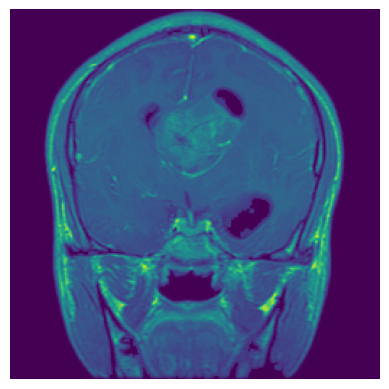

In [ ]:
n=0
plt.axis("off")
plt.imshow(x_tr[n])
print(y_tr[n])

1


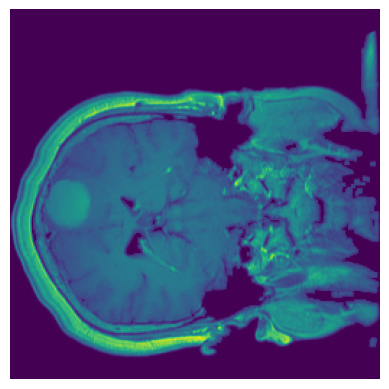

In [ ]:
n=5616
plt.axis("off")
plt.imshow(x_tr[n])
print(y_train[n])

Codificación One-Hot, normalización y reordenamiento.

In [ ]:
train_y = np.eye(4)[y_train.reshape(-1)]
test_y = np.eye(4)[y_test.reshape(-1)]

In [ ]:
x_train = x_tr.astype('float32') / 255.0
x_test = x_te.astype('float32') / 255.0

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

x_train, train_y = unison_shuffled_copies(x_train, train_y)

#Modelo


Usamos el mismo modelo que en el primer notebook.

In [ ]:
def architecture_o(input_shape, num_classes, activation, dropout=False, batch_normalization=False):

    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     padding='same',
                     kernel_initializer='glorot_uniform',
                     bias_initializer='zeros',
                     input_shape=input_shape))

    model.add(Activation(activation))
    if batch_normalization:
        model.add(BatchNormalization())

    model.add(MaxPooling2D())

    model.add(Conv2D(filters=64,kernel_size=3,padding='same',kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model.add(Activation(activation))
    if batch_normalization:
        model.add(BatchNormalization())

    model.add(MaxPooling2D())

    model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'glorot_uniform',bias_initializer='zeros'))
    model.add(Activation(activation))
    if batch_normalization:
        model.add(BatchNormalization())

    model.add(MaxPooling2D())

    model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'glorot_uniform',bias_initializer='zeros'))
    model.add(Activation(activation))
    if batch_normalization:
        model.add(BatchNormalization())

    model.add(MaxPooling2D())

    model.add(Flatten())
    if dropout:
        model.add(Dropout(0.50))

    model.add(Dense(128, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model.add(Activation(activation))
    if batch_normalization:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(0.50))

    model.add(Dense(num_classes))
    model.add(Activation('softmax',name='Model'))

    return model

In [ ]:
one_image = (256, 256, 1)
activation='relu'
num_classes = 4
dropout=True
batch_normalization=True

model = architecture_o(one_image,num_classes,activation,dropout,batch_normalization)

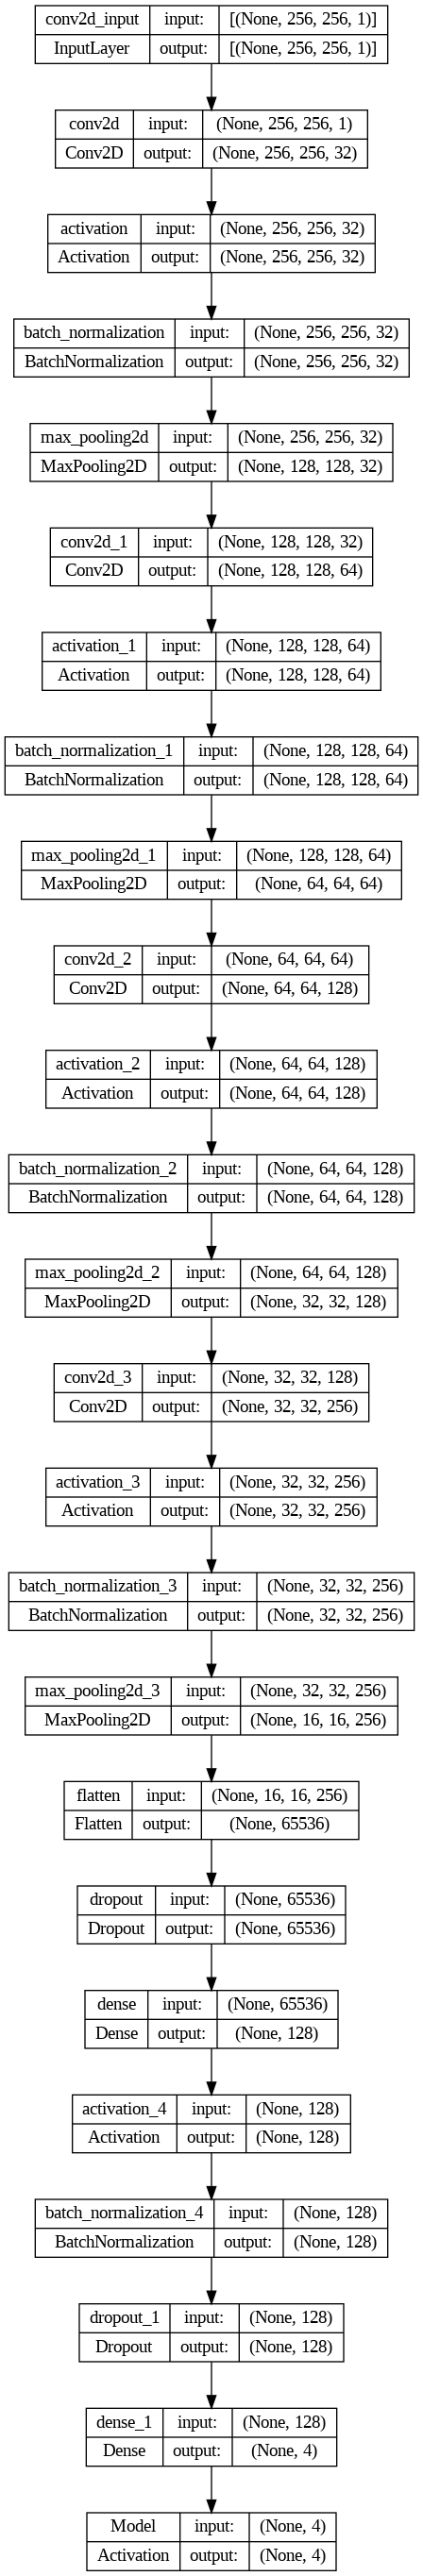

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, rankdir='TB', show_layer_names=True)

In [ ]:
learning_rate = 0.01

optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0, nesterov=False)

In [ ]:
loss_function = 'categorical_crossentropy'
metric_function = 'accuracy'

In [ ]:
model.compile(optimizer = optimizer, loss = loss_function, metrics = [metric_function])

Realizamos el entrenamiento con 10% de los datos para validación.

In [ ]:
start_time = time.time()

validation_portion = 0.1
batch_size=128
num_epochs = 100

callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)

history = model.fit(x=x_train, y=train_y, epochs=num_epochs, batch_size=batch_size, \
                            validation_split=validation_portion, shuffle=True,
                            callbacks=[callback], verbose=1)

end_time = time.time()
print("Time for training: {:10.4f}s".format(end_time - start_time))

Epoch 1/100
90/90 [==============================] - 50s 374ms/step - loss: 1.1068 - accuracy: 0.6049 - val_loss: 1.4298 - val_accuracy: 0.2575
Epoch 2/100
90/90 [==============================] - 29s 322ms/step - loss: 0.6852 - accuracy: 0.7482 - val_loss: 3.8884 - val_accuracy: 0.2355
Epoch 3/100
90/90 [==============================] - 30s 335ms/step - loss: 0.5412 - accuracy: 0.8007 - val_loss: 2.9266 - val_accuracy: 0.2394
Epoch 4/100
90/90 [==============================] - 30s 336ms/step - loss: 0.4266 - accuracy: 0.8406 - val_loss: 1.8098 - val_accuracy: 0.4631
Epoch 5/100
90/90 [==============================] - 30s 332ms/step - loss: 0.3578 - accuracy: 0.8658 - val_loss: 2.1122 - val_accuracy: 0.4341
Epoch 6/100
90/90 [==============================] - 30s 334ms/step - loss: 0.3114 - accuracy: 0.8879 - val_loss: 0.7645 - val_accuracy: 0.7480
Epoch 7/100
90/90 [==============================] - 30s 333ms/step - loss: 0.2807 - accuracy: 0.8973 - val_loss: 1.2713 - val_accuracy:

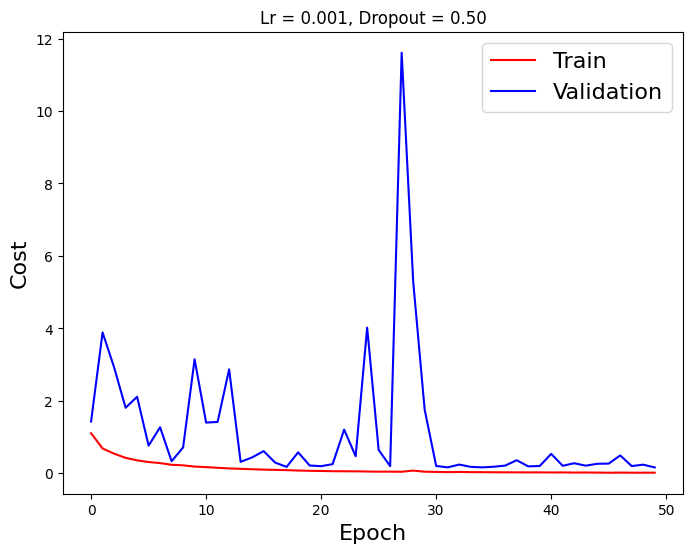

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.title('Lr = 0.001, Dropout = 0.50')
plt.ylabel('Cost', size=16)
plt.xlabel('Epoch',size=16)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=16)
plt.show()

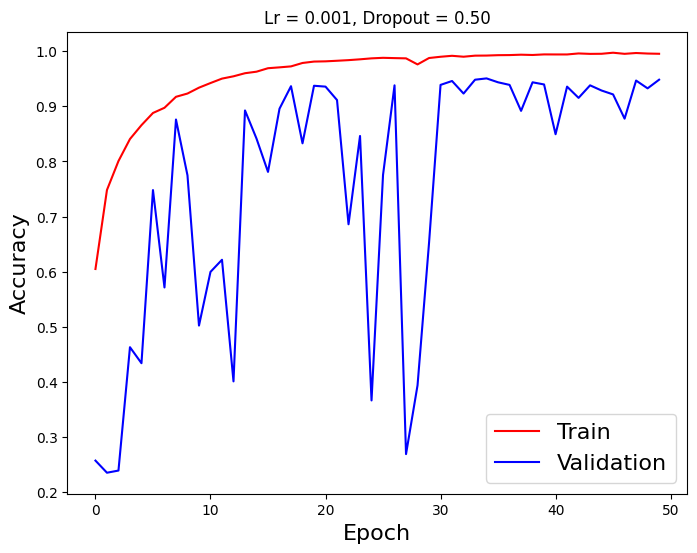

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'], color='blue')
plt.title('Lr = 0.001, Dropout = 0.50')
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='lower right', fontsize=16)
plt.show()

In [ ]:
evaluations = model.evaluate(x = x_test, y = test_y)

print ("Loss = " + str(evaluations[0]))
print ("Test Accuracy = " + str(evaluations[1]))

10/10 [==============================] - 1s 62ms/step - loss: 0.9266 - accuracy: 0.7727
Loss = 0.9265871644020081
Test Accuracy = 0.7727272510528564


In [ ]:
predictions = model.predict(x_test)
sample = 31
prediction = np.argmax(predictions[sample])

print('Para la imagen', sample, 'la predicción es', dic[prediction])

10/10 [==============================] - 0s 20ms/step
Para la imagen 31 la predicción es glioma


La imagen 31 es un glioma


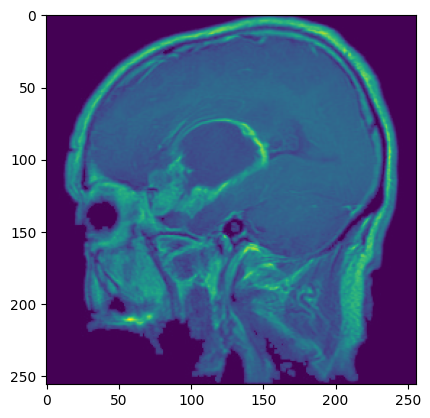

In [ ]:
plt.imshow(x_test[sample])

print('La imagen', sample, 'es un', dic[int(np.argmax(test_y[sample]))])

Hubo una mejora al usar más datos, pero no fue demasiado significativa. También cambie la activación a relu. Puede ser que con más datos y algún ajuste a la arquitectura se tengan mejores resultados.